***Problem Statement:***     
             To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q keras

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir=pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration')

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# Let's count the total images in test & train folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


###using keras.preprocessing
###Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#using 80% images for training & 20% for testing
class_names1=np.array([item.name for item in data_dir.glob('Train/*')])
class_names1

array(['actinic keratosis', 'melanoma', 'dermatofibroma',
       'squamous cell carcinoma', 'basal cell carcinoma',
       'seborrheic keratosis', 'pigmented benign keratosis',
       'vascular lesion', 'nevus', 'output'], dtype='<U26')

In [ ]:
# train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


In [ ]:
#validatation data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


In [ ]:
#listing out the class names for Skin Cancer & storing them on a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


__Visualizing the data__

In [ ]:
image_generator=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen=image_generator.flow_from_directory(directory=data_dir_train,batch_size=batch_size,
                                                   shuffle=True,target_size=(img_height,img_width),classes=list(class_names))

Found 2239 images belonging to 9 classes.


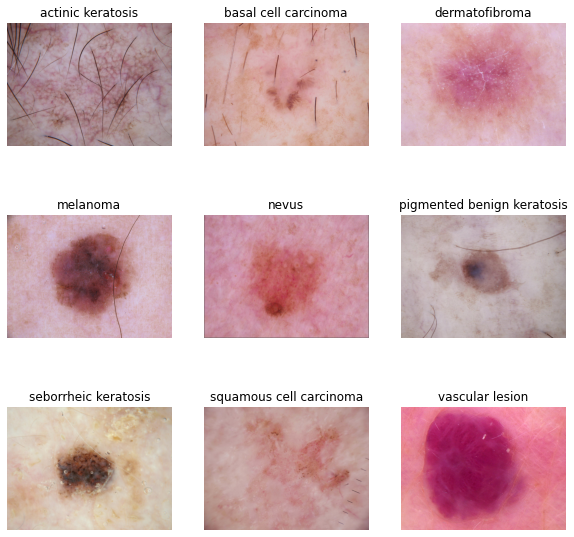

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for index,name in enumerate(class_names):
   ax=plt.subplot(3,3,index+1)
   images=list(data_dir_train.glob(name+'/*'))
   img=mpimg.imread((str(images[0])))
   plt.imshow(img)
   plt.title(name)
   plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). A batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###Creating the model

In [ ]:
num_classes = 9
# creating the model
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='softmax'),
#   layers.Dense(num_classes)
# ])
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

###Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

###Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 301s 2s/step - loss: 1.9350 - accuracy: 0.2835 - val_loss: 1.7262 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: 1.5719 - accuracy: 0.4520 - val_loss: 1.6290 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 59s 1s/step - loss: 1.4123 - accuracy: 0.5262 - val_loss: 1.3831 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 1.2841 - accuracy: 0.5513 - val_loss: 1.4680 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 60s 1s/step - loss: 1.1786 - accuracy: 0.5915 - val_loss: 1.3365 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 58s 1s/step - loss: 1.0908 - accuracy: 0.6172 - val_loss: 1.3988 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 59s 1s/step - loss: 1.0142 - accuracy: 0.6390 - val_loss: 1.4301 - val_accuracy: 0.5503
Epoch 8/20
56/56 [============

###Visulalizing the train results

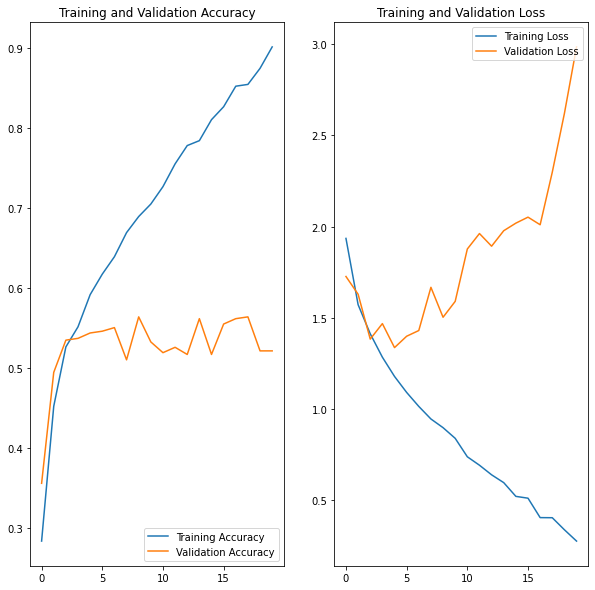

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_dir_train)

<BarContainer object of 9 artists>

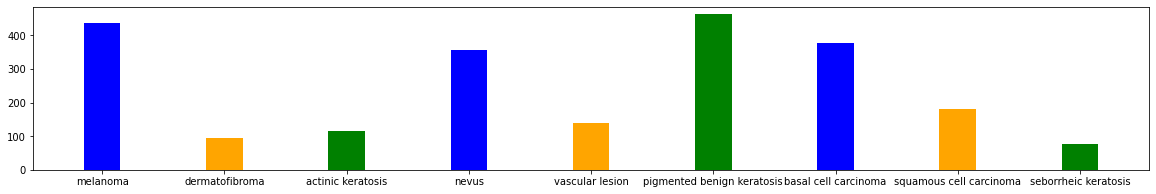

In [ ]:
from collections import Counter
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.figure(figsize=(20, 3))
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'],width=0.3)

Write your findings here:
- Which class has the least number of samples?
    dermatofibrome
- Which classes dominate the data in terms proportionate number of samples?
pigmented bengn keratosis basal

To Rectify the class imbalance

In [ ]:
pip install Augmentor

In [ ]:
# creating image
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

OSError: ignored

In [ ]:
# count created image total
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


In [ ]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)
print(path_list_new)

[]
